In [ ]:
#!pip install scipy tensorflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# ===============================
# 1. Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')


# ===============================
# 2. Imports & Config
# ===============================
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content/drive/MyDrive/21_12_dataset")
ABS_COL = "Absorbance (AU)"
HEADER_KEY = "Wavelength (nm)"


# ===============================
# 3. Sanity checks
# ===============================
print("Folder exists:", DATA_DIR.exists())

csv_files = sorted(DATA_DIR.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files")

for f in csv_files[:5]:
    print(f.name)


# ===============================
# 4. Load CSVs → rows
# ===============================
rows = []
labels = []

for csv_path in csv_files:
    try:
        # ----- extract label -----
        name = csv_path.name
        if "Hadamard" not in name:
            raise ValueError("Filename does not contain 'Hadamard'")
        label = name.split("Hadamard")[0].strip()

        # ----- find real header row -----
        with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        header_row = None
        for i, line in enumerate(lines):
            if HEADER_KEY in line:
                header_row = i
                break

        if header_row is None:
            raise ValueError("Could not find data header row")

        # ----- read numeric table only -----
        df = pd.read_csv(csv_path, skiprows=header_row)

        if ABS_COL not in df.columns:
            raise ValueError(f"Missing column '{ABS_COL}'")

        absorbance = df[ABS_COL].values

        rows.append(absorbance)
        labels.append(label)

    except Exception as e:
        print(f"Skipped {csv_path.name}: {e}")


# ===============================
# 5. Build final DataFrame
# ===============================
df = pd.DataFrame(rows)
df["label"] = labels

print("\n✅ Data loaded successfully")
print("Final shape:", df.shape)
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder exists: True
Found 150 CSV files
msgHadamard 1_404001_20251211_210222.csv
msgHadamard 1_404002_20251211_210306.csv
msgHadamard 1_404003_20251211_210320.csv
msgHadamard 1_404004_20251211_210333.csv
msgHadamard 1_404005_20251211_210343.csv

✅ Data loaded successfully
Final shape: (150, 229)


,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,label
0,0.438432,0.434472,0.440163,0.427325,0.430162,0.416258,0.412754,0.422910,0.423841,0.414793,...,0.872203,0.874162,0.903221,0.942379,0.933661,0.908627,0.896012,0.936568,1.004954,msg
1,0.372459,0.370886,0.366272,0.350559,0.350841,0.342019,0.349293,0.336543,0.347540,0.347739,...,0.731849,0.771212,0.769399,0.800836,0.820173,0.789304,0.851078,0.760087,0.853623,msg
2,0.303517,0.298925,0.288689,0.304806,0.315987,0.310721,0.300993,0.299146,0.308751,0.304308,...,0.623068,0.636551,0.641597,0.698338,0.710181,0.742794,0.701478,0.669470,0.725814,msg
3,0.428297,0.423471,0.430097,0.409033,0.408164,0.399753,0.415970,0.413326,0.410960,0.415961,...,0.846825,0.860591,0.893989,0.903453,0.920774,0.891879,0.967321,0.952192,0.964132,msg
4,0.492044,0.510267,0.463957,0.502052,0.496792,0.521736,0.485020,0.484276,0.484116,0.484770,...,0.919003,0.951606,0.941102,1.036169,1.014212,1.068870,0.990633,0.955516,0.890546,msg


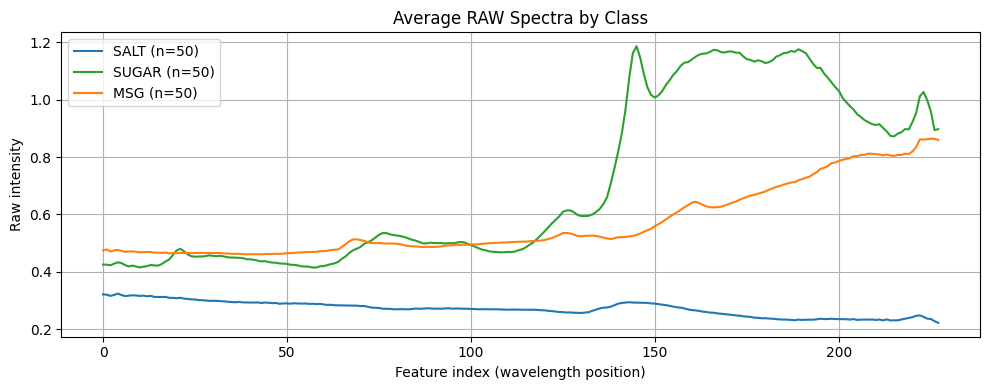

In [ ]:
y = df.iloc[:, -1].values

# Features are all columns except last, but keep only numeric ones
X_raw = (
    df.iloc[:, :-1]
      .apply(pd.to_numeric, errors='coerce')  # non-numeric -> NaN
      .astype(np.float32)
      .values
)

# Class masks
salt_mask  = (y == 'salt')
sugar_mask = (y == 'sugar')
msg_mask   = (y == 'msg')

# Class averages (ignore NaNs just in case)
salt_mean  = np.nanmean(X_raw[salt_mask], axis=0)
sugar_mean = np.nanmean(X_raw[sugar_mask], axis=0)
msg_mean   = np.nanmean(X_raw[msg_mask], axis=0)

# Sample counts
n_salt, n_sugar, n_msg = salt_mask.sum(), sugar_mask.sum(), msg_mask.sum()

# Plot RAW class averages
plt.figure(figsize=(10, 4))
plt.plot(salt_mean,  color='tab:blue',   label=f'SALT (n={n_salt})')
plt.plot(sugar_mean, color='tab:green',  label=f'SUGAR (n={n_sugar})')
plt.plot(msg_mean,   color='tab:orange', label=f'MSG (n={n_msg})')

plt.xlabel('Feature index (wavelength position)')
plt.ylabel('Raw intensity')
plt.title('Average RAW Spectra by Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Features and labels
X = df.iloc[:, :-1].astype(np.float32).values
y = df.iloc[:, -1].values

# Compute deltas: shape becomes (num_samples, 227)
X = np.diff(X, axis=1).astype(np.float32)

print("New X shape (deltas):", X.shape)
print("Example row deltas:", X[0][:10])

print("Example labels:", np.unique(y))

New X shape (deltas): (150, 227)
Example row deltas: [-0.00396001  0.00569099 -0.01283798  0.002837   -0.01390401 -0.00350401
  0.01015601  0.00093099 -0.00904799  0.00448897]
Example labels: ['msg' 'salt' 'sugar']


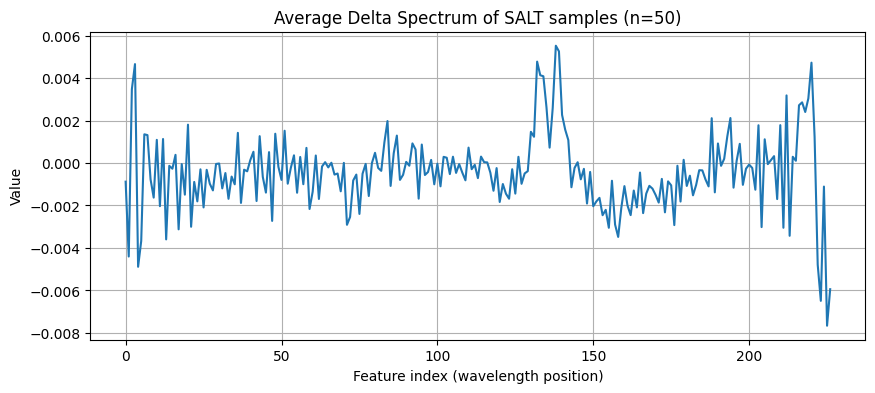

In [ ]:
# Select all SALT samples
salt_mask = (y == 'salt')
salt_specs = X[salt_mask]
n_salt = salt_specs.shape[0]

# Compute average spectrum
salt_mean_spec = salt_specs.mean(axis=0)

plt.figure(figsize=(10, 4))
plt.plot(range(len(salt_mean_spec)), salt_mean_spec)
plt.xlabel('Feature index (wavelength position)')
plt.ylabel('Value')
plt.title(f'Average Delta Spectrum of SALT samples (n={n_salt})')
plt.grid(True)
plt.show()

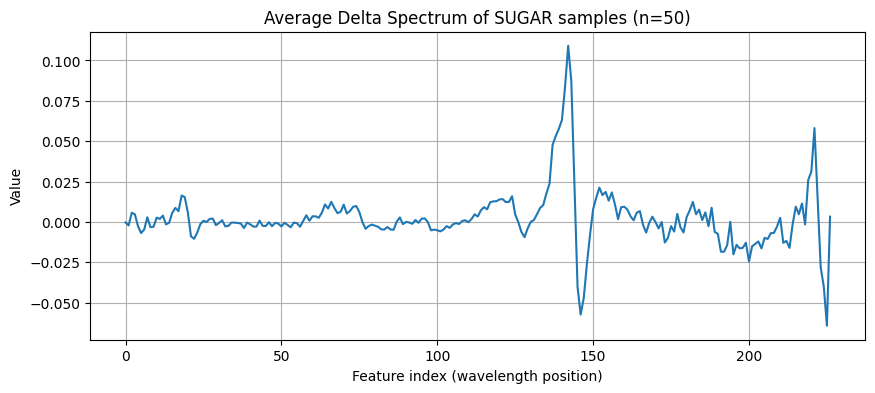

In [ ]:
# Select all SUGAR samples
sugar_mask = (y == 'sugar')
sugar_specs = X[sugar_mask]
n_sugar = sugar_specs.shape[0]

# Compute average spectrum
sugar_mean_spec = sugar_specs.mean(axis=0)

plt.figure(figsize=(10, 4))
plt.plot(range(len(sugar_mean_spec)), sugar_mean_spec)
plt.xlabel('Feature index (wavelength position)')
plt.ylabel('Value')
plt.title(f'Average Delta Spectrum of SUGAR samples (n={n_sugar})')
plt.grid(True)
plt.show()

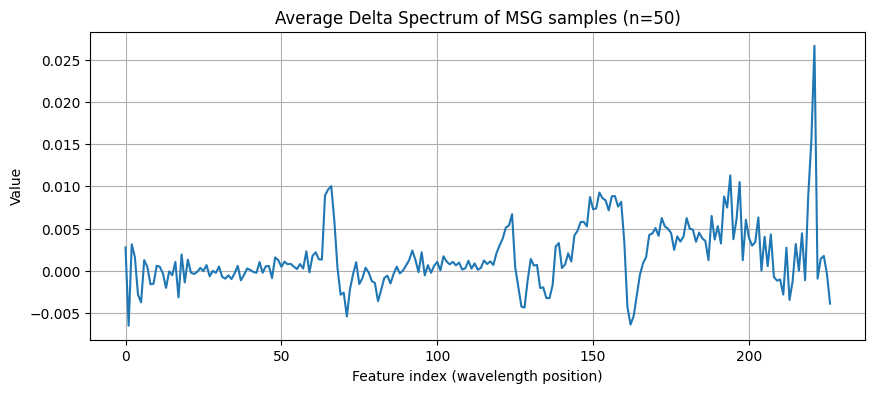

In [ ]:
# Select all MSG samples
msg_mask = (y == 'msg')
msg_specs = X[msg_mask]
n_msg = msg_specs.shape[0]

# Compute average spectrum
msg_mean_spec = msg_specs.mean(axis=0)

plt.figure(figsize=(10, 4))
plt.plot(range(len(msg_mean_spec)), msg_mean_spec)
plt.xlabel('Feature index (wavelength position)')
plt.ylabel('Value')
plt.title(f'Average Delta Spectrum of MSG samples (n={n_msg})')
plt.grid(True)
plt.show()

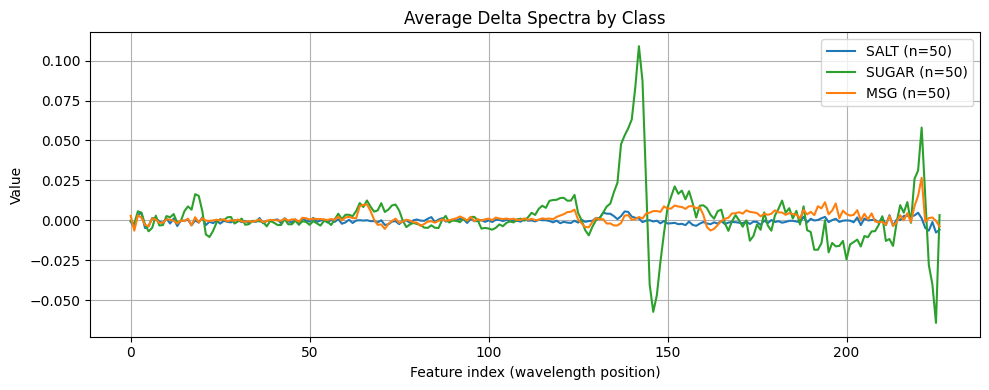

In [ ]:
# --- Compute class means ---
salt_mean_spec  = X[y == 'salt'].mean(axis=0)
sugar_mean_spec = X[y == 'sugar'].mean(axis=0)
msg_mean_spec   = X[y == 'msg'].mean(axis=0)

n_salt  = np.sum(y == 'salt')
n_sugar = np.sum(y == 'sugar')
n_msg   = np.sum(y == 'msg')

# --- Plot together with fixed colors ---
plt.figure(figsize=(10, 4))

plt.plot(salt_mean_spec,  color='tab:blue',   label=f'SALT (n={n_salt})')
plt.plot(sugar_mean_spec, color='tab:green',  label=f'SUGAR (n={n_sugar})')
plt.plot(msg_mean_spec,   color='tab:orange', label=f'MSG (n={n_msg})')

plt.xlabel('Feature index (wavelength position)')
plt.ylabel('Value')
plt.title('Average Delta Spectra by Class')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


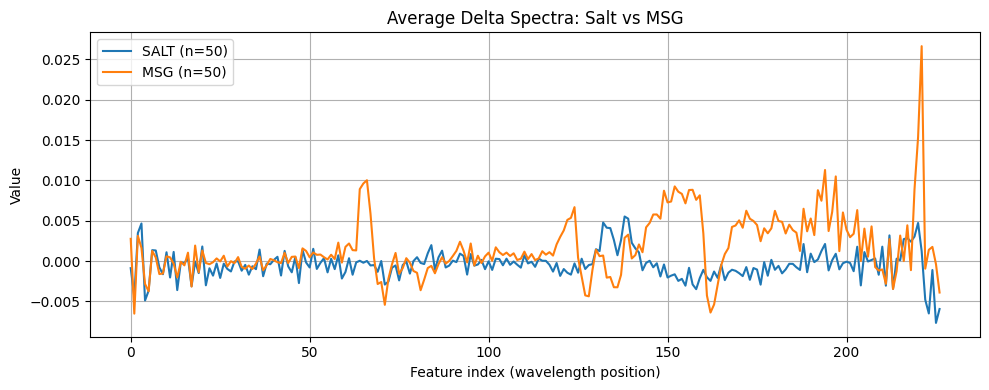

In [ ]:
# --- Compute class means ---
salt_mean_spec  = X[y == 'salt'].mean(axis=0)
msg_mean_spec   = X[y == 'msg'].mean(axis=0)

n_salt  = np.sum(y == 'salt')
n_msg   = np.sum(y == 'msg')

# --- Plot together with fixed colors ---
plt.figure(figsize=(10, 4))

plt.plot(salt_mean_spec,  color='tab:blue',   label=f'SALT (n={n_salt})')
plt.plot(msg_mean_spec,   color='tab:orange', label=f'MSG (n={n_msg})')

plt.xlabel('Feature index (wavelength position)')
plt.ylabel('Value')
plt.title('Average Delta Spectra: Salt vs MSG')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
val_size = 0.2
test_size = 0.125
random_state = 42
is_shuffle = True

#Split train and val set
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=val_size, stratify=y_encoded, random_state=random_state, shuffle=is_shuffle
)

#Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, stratify=y_train, random_state=random_state, shuffle=is_shuffle
)

print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape, "X_test shape:", X_test.shape)
print("Training label distribution:", np.bincount(y_train))
print("Validation label distribution:", np.bincount(y_val))

X_train shape: (105, 227) X_val shape: (30, 227) X_test shape: (15, 227)
Training label distribution: [35 35 35]
Validation label distribution: [10 10 10]


In [ ]:
N_AUG = 5  # Set to 0 to skip augmentation

def augment_spectrum(x, std_global):
    offset = np.random.uniform(-0.6 * std_global, 0.6 * std_global)
    mult   = 1.0 + np.random.uniform(-0.6, 0.6)
    slope  = np.random.uniform(0.95, 1.05)
    ramp = np.linspace(-0.5, 0.5, len(x))
    x_aug = (x + offset) * mult + slope * ramp
    return x_aug.astype(np.float32)

def build_augmented_train_set(X_train, y_train, n_aug=5):
    std_global = X_train.std()
    X_list, y_list = [X_train], [y_train]
    for _ in range(n_aug):
        X_aug = np.vstack([augment_spectrum(x, std_global) for x in X_train])
        X_list.append(X_aug)
        y_list.append(y_train)
    return np.vstack(X_list), np.concatenate(y_list)

X_train_aug, y_train_aug = build_augmented_train_set(X_train, y_train, n_aug=N_AUG)
print("Augmented train shape:", X_train_aug.shape)

Augmented train shape: (630, 227)


In [ ]:
# Reshape for CNN input
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_val_cnn shape:", X_val_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

X_train_cnn shape: (105, 227, 1)
X_val_cnn shape: (30, 227, 1)
X_test_cnn shape: (15, 227, 1)


In [ ]:
# Build CNN model
def build_cnn(input_len, num_classes):
    inputs = keras.Input(shape=(input_len, 1))
    x = layers.GaussianNoise(0.05)(inputs)
    x = layers.Conv1D(16, 8, activation='relu', padding='same')(x)
    x = layers.Conv1D(32, 16, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

input_len = X_train_cnn.shape[1]
model = build_cnn(input_len, num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 227, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 227, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 227, 16)        │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 227, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7264)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7264)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       929,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 938,675 (3.58 MB)

 Trainable params: 938,675 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train model
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3019 - loss: 1.1028 - val_accuracy: 0.6667 - val_loss: 1.0845 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6523 - loss: 1.0826 - val_accuracy: 0.6667 - val_loss: 1.0495 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5634 - loss: 1.0340 - val_accuracy: 0.6667 - val_loss: 0.8088 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5873 - loss: 0.8020 - val_accuracy: 0.7667 - val_loss: 0.5044 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6735 - loss: 0.6597 - val_accuracy: 1.0000 - val_loss: 0.3755 - learning_rate: 0.0010
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7523 - loss: 0.5316 - val_accuracy: 1.0000 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7697 - loss: 0.4369 - val_acc

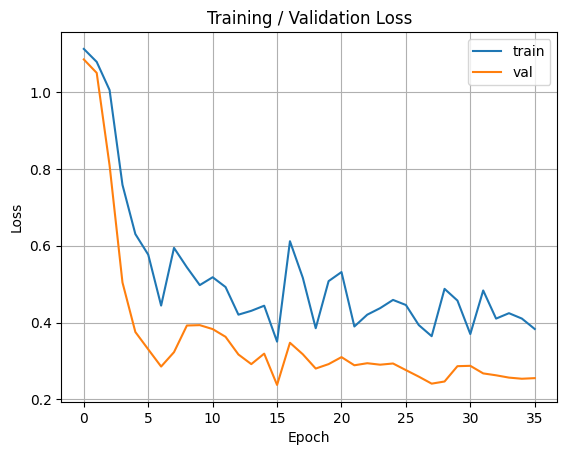

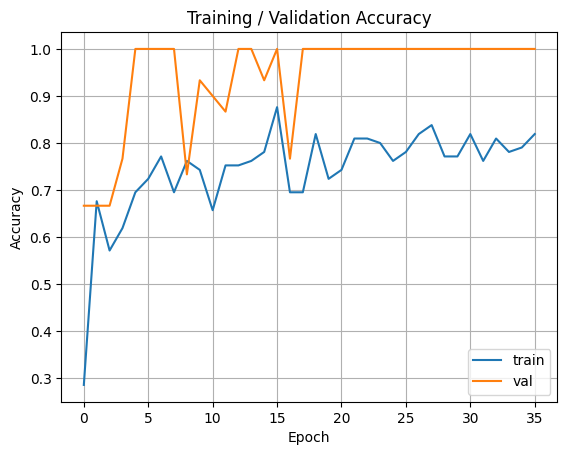

In [ ]:
# plot training graphs
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training / Validation Loss')
plt.legend(); plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training / Validation Accuracy')
plt.legend(); plt.grid(True)
plt.show()


In [ ]:
# Predict on test set (demo)
y_pred_prob = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_labels = le.inverse_transform(y_pred)

print("Predicted labels for samples:", y_pred_labels[:])
print("True labels for samples:", le.inverse_transform(y_test[:]))
print("Predicted probabilities for first 5 samples:\n", y_pred_prob[:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted labels for samples: ['msg' 'sugar' 'msg' 'salt' 'salt' 'sugar' 'salt' 'msg' 'msg' 'sugar'
 'sugar' 'salt' 'msg' 'sugar' 'salt']
True labels for samples: ['msg' 'sugar' 'msg' 'salt' 'salt' 'sugar' 'salt' 'msg' 'msg' 'sugar'
 'sugar' 'salt' 'msg' 'sugar' 'salt']
Predicted probabilities for first 5 samples:
 [[5.82610190e-01 4.03628439e-01 1.37613015e-02]
 [2.19611844e-04 1.50409222e-04 9.99629915e-01]
 [5.95086932e-01 3.90451491e-01 1.44615564e-02]
 [2.43142620e-01 7.30204403e-01 2.66529582e-02]
 [2.36655727e-01 7.33376205e-01 2.99680810e-02]
 [3.22751876e-04 2.61793786e-04 9.99415517e-01]
 [2.41505712e-01 7.33461559e-01 2.50326991e-02]
 [6.27510309e-01 3.56471092e-01 1.60186123e-02]
 [6.54829919e-01 3.32516998e-01 1.26530901e-02]
 [8.63764362e-05 4.94010383e-05 9.99864221e-01]
 [1.32115281e-04 8.47911870e-05 9.99783099e-01]
 [2.43828908e-01 7.27854133e-01 2.83169206e-02]
 [6.72512591e-01 3.15964669e-01 1.15227103e-02]
 [1.44976133e-04 1.19

Export TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved FLOAT32 model.tflite")


Saved artifact at '/tmp/tmpa4qvvu_i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 227, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140340167388880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340167392912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340167387728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340167391760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340167391184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340167390992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340167390032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340167392336: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved FLOAT32 model.tflite


In [ ]:
idx = 0
sample = X_val_cnn[idx:idx+1]
true_label = y_val[idx]

pred = model.predict(sample)
pred_label = np.argmax(pred, axis=1)[0]

print("True:", le.inverse_transform([true_label])[0])
print("Pred:", le.inverse_transform([pred_label])[0])
print("Probabilities:", pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
True: msg
Pred: msg
Probabilities: [0.58742744 0.39607596 0.01649653]


In [ ]:
RUN_TEST = False

if RUN_TEST:
  # ============================================================
  # Quick test: run a CSV through your TFLite model
  # ============================================================
  import os
  import json

  def plot_absorbance(df):
      """Plot absorbance data from the CSV."""
      cols = [c.strip().lower() for c in df.columns]
      df.columns = cols

      # y-axis: absorbance values
      if "absorbance" in df.columns:
          y = df["absorbance"].astype(float)
      else:
          y = df[df.columns[-1]].astype(float)

      # x-axis: wavelength if present
      if "wavelength" in df.columns:
          x = df["wavelength"].astype(float)
          xlabel = "Wavelength (nm)"
      else:
          x = range(len(y))
          xlabel = "Sample Index"

      plt.figure(figsize=(12, 4))
      plt.plot(x, y)
      plt.title("Absorbance Spectrum")
      plt.xlabel(xlabel)
      plt.ylabel("Absorbance")
      plt.grid(True)
      plt.show()


  def run_tflite_on_array(model_path: str, x: np.ndarray):
      """Run a 1D spectrum through a TFLite model. Returns (probs, raw_output, input_details, output_details)."""
      interp = tf.lite.Interpreter(model_path=model_path)
      interp.allocate_tensors()
      inp = interp.get_input_details()[0]
      out = interp.get_output_details()[0]

      # Determine expected shape
      expected_shape = tuple(int(s) for s in inp['shape'])

      # typical: (1, N) or (1, N, 1)
      if len(expected_shape) == 3:
          _, N, C = expected_shape
          if C == 1:
              x_resh = x.reshape((1, N, 1))
          else:
              x_resh = x.reshape((1, N, C))
      elif len(expected_shape) == 2:
          _, N = expected_shape
          x_resh = x.reshape((1, N))
      else:
          raise RuntimeError(f"Unsupported input shape: {expected_shape}")

      # Resample if mismatch
      expected_N = x_resh.shape[1]
      if x.shape[0] != expected_N:
          xp = np.linspace(0, 1, x.shape[0])
          x = np.interp(np.linspace(0, 1, expected_N), xp, x).astype(np.float32)
          if len(expected_shape) == 3 and expected_shape[2] == 1:
              x_resh = x.reshape((1, expected_N, 1))
          else:
              x_resh = x.reshape((1, expected_N))

      # Quantize input if needed
      if inp['dtype'] == np.int8:
          scale, zero_point = inp['quantization']
          if scale == 0:
              raise RuntimeError("Input quantization scale is 0")
          x_q = np.round(x_resh / scale + zero_point).astype(np.int8)
          interp.set_tensor(inp['index'], x_q)
      else:
          interp.set_tensor(inp['index'], x_resh.astype(inp['dtype']))

      # Run model
      interp.invoke()
      raw_out = interp.get_tensor(out['index']).squeeze()

      # Dequantize output
      out_scale, out_zp = out['quantization']
      if out_scale != 0:
          probs = (raw_out.astype(np.int32) - out_zp) * out_scale
      else:
          probs = raw_out.astype(np.float32)

      # Normalize if needed
      if probs.ndim == 1 and not np.isclose(probs.sum(), 1.0, atol=1e-3):
          z = probs - np.max(probs)
          e = np.exp(z)
          probs = e / e.sum()

      return probs, raw_out, inp, out


  # ============================================================
  # Upload the CSV
  # ============================================================

  from google.colab import files
  print("Upload your CSV file (absorbance data)")
  uploaded = files.upload()

  uploaded_files = list(uploaded.keys())
  print("Uploaded:", uploaded_files)

  csv_file = None
  for fn in uploaded_files:
      if fn.lower().endswith('.csv') and csv_file is None:
          csv_file = fn

  if csv_file is None:
      raise RuntimeError("No .csv file uploaded.")

  # IMPORTANT: model.tflite must already be in the working directory
  model_file = "model.tflite"
  if not os.path.exists(model_file):
      raise RuntimeError("model.tflite NOT FOUND in project directory.")

  print("Using model file:", model_file)
  print("CSV file:", csv_file)


  # ============================================================
  # Load CSV absorbance values
  # ============================================================

  df = pd.read_csv(csv_file)

  # ---- NEW: plot the absorbance data ----
  plot_absorbance(df)

  cols = [c.strip().lower() for c in df.columns]
  df.columns = cols

  if "absorbance" in df.columns:
      arr_raw = df["absorbance"].astype(np.float32).to_numpy()
      arr = np.diff(arr_raw).astype(np.float32)
      print("Using delta input, len =", len(arr))

      # ---- NEW: plot the delta spectrum ----
      plt.figure(figsize=(12, 4))
      plt.plot(range(len(arr)), arr)
      plt.title("Delta Spectrum (x[i+1] - x[i])")
      plt.xlabel("Index")
      plt.ylabel("Delta Absorbance")
      plt.grid(True)
      plt.show()

  else:
      last_col = df.columns[-1]
      print('No "absorbance" column found — using last column:', last_col)
      arr_raw = df["absorbance"].astype(np.float32).to_numpy()
      arr = np.diff(arr_raw).astype(np.float32)
      print("Using delta input, len =", len(arr))

  print("Input length:", arr.shape[0])
  print("First 5 values:", arr[:5])


  # ============================================================
  # Run inference
  # ============================================================

  probs, raw, inp_det, out_det = run_tflite_on_array(model_file, arr)

  print("\nInput details:", inp_det)
  print("Output details:", out_det)
  print("\nOutput probabilities:", probs)
  print("argmax index:", int(np.argmax(probs)))


  # ============================================================
  # Label resolution
  # ============================================================

  labels = None

  # Try session LabelEncoder
  if "le" in globals():
      try:
          labels = list(globals()["le"].classes_)
          print("\nUsing LabelEncoder classes:", labels)
      except:
          labels = None

  # Try label_map.json in directory
  if labels is None and os.path.exists("label_map.json"):
      with open("label_map.json", "r") as fh:
          labels = json.load(fh)
      print("\nLoaded label_map.json:", labels)

  # Fallback default
  if labels is None:
      print("\nNo label map found. Using default CLASS_NAMES.")
      labels = ["msg", "salt", "sugar"]
      print("Using labels:", labels)

  idx = int(np.argmax(probs))
  print("\nPredicted label:", labels[idx], f"(index {idx})")
  print("Confidence:", float(probs[idx]))


  # ============================================================
  # Save probabilities to CSV + download
  # ============================================================

  out_df = pd.DataFrame({"label": labels, "prob": probs})
  out_df.to_csv("inference_result.csv", index=False)
  print("\nSaved inference_result.csv")
else:
  print("Skipping test")


Skipping test
